In [1]:
#安装组件，安装完成需要重新启动一下kernel
!pip3 install scikit-image
!pip3 install opencv-python
!pip3 install torchvision
!pip3 install torchsummary
!pip3 install torchviz

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import numpy as np
import  
import matplotlib.pyplot as plt
import os
from skimage import io

%matplotlib inline

In [8]:
import oss2
access_key_id = os.getenv('OSS_TEST_ACCESS_KEY_ID', 'LTAI4G1MuHTUeNrKdQEPnbph')
access_key_secret = os.getenv('OSS_TEST_ACCESS_KEY_SECRET', 'm1ILSoVqcPUxFFDqer4tKDxDkoP1ji')
bucket_name = os.getenv('OSS_TEST_BUCKET', 'mldemo')
endpoint = os.getenv('OSS_TEST_ENDPOINT', 'https://oss-cn-shanghai.aliyuncs.com')
# 创建Bucket对象，所有Object相关的接口都可以通过Bucket对象来进行
bucket = oss2.Bucket(oss2.Auth(access_key_id, access_key_secret), endpoint, bucket_name)
# 下载到本地文件
bucket.get_object_to_file('data/c12/number_plate_data.zip', 'number_plate_data.zip')

In [9]:
!unzip -q -o number_plate_data.zip
!rm -rf __MACOSX

In [11]:
data_dir_train = 'gen_res'
data_dir_val = 'gen_res_val'

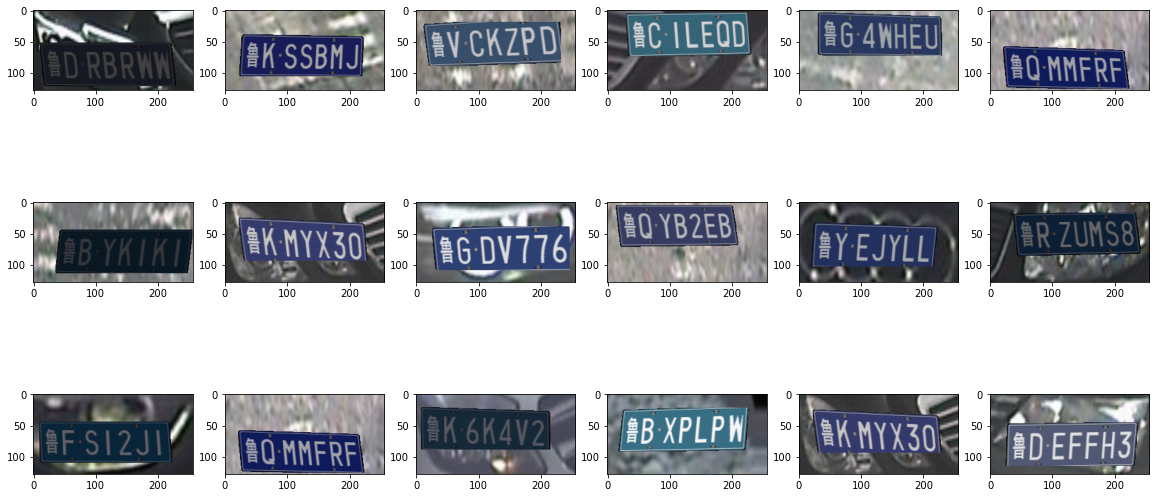

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
# 随机选择18张照片
train_folder = data_dir_train+"/15/"

images = random.choices(os.listdir(train_folder), k=18)

fig = plt.figure(figsize=(20, 10))

# 6列
columns = 6
# 3行
rows = 3

# 依次可视化
for x, i in enumerate(images):
    path =  os.path.join(train_folder,i)
    img = plt.imread(path)
    fig.add_subplot(rows, columns, x+1)
    plt.imshow(img)
    
plt.show()

In [13]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.relu0 = nn.ReLU()
        # 最大池化
        self.pool0 = nn.MaxPool2d(2, stride=2)
        
        self.conv1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, stride=2)
        
        self.conv2d_1 = nn.Conv2d(128, 256, (1,5), stride=1)
        self.batch_normalization_1 = nn.BatchNorm2d(256)
        self.activation_1 = nn.ReLU()
        
        self.conv2d_2 = nn.Conv2d(256, 256, (7,1), stride=1, padding=(3,0))
        self.batch_normalization_2 = nn.BatchNorm2d(256)
        self.activation_2 = nn.ReLU()
        
        self.conv2d_3 = nn.Conv2d(256, 256, (5,1), stride=1, padding=(2,0))
        self.batch_normalization_3 = nn.BatchNorm2d(256)
        self.activation_3 = nn.ReLU()
        
        self.conv2d_4 = nn.Conv2d(256, 256, (3,1), stride=1, padding=(1,0))
        self.batch_normalization_4 = nn.BatchNorm2d(256)
        self.activation_4 = nn.ReLU()
        
        self.conv2d_5 = nn.Conv2d(256, 256, (1,1), stride=1)
        self.batch_normalization_5 = nn.BatchNorm2d(256)
        self.activation_5 = nn.ReLU()
        
        self.conv_1024_11 = nn.Conv2d(1024, 1024, 1, stride=1)
        self.batch_normalization_6 = nn.BatchNorm2d(1024)
        self.activation_6 = nn.ReLU()
        
        self.conv_class_11 = nn.Conv2d(1024, 84, 1, stride=1)
    def forward(self, x):
        x = self.pool0(self.relu0(self.bn0(self.conv0(x))))
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.activation_1(self.batch_normalization_1(self.conv2d_1(x)))
        
        x2 = self.activation_2(self.batch_normalization_2(self.conv2d_2(x)))
        x3 = self.activation_3(self.batch_normalization_3(self.conv2d_3(x)))
        x4 = self.activation_4(self.batch_normalization_4(self.conv2d_4(x)))
        x5 = self.activation_5(self.batch_normalization_5(self.conv2d_5(x)))
        
        x = torch.cat([x2, x3, x4, x5], dim=1)
        
        x = self.activation_6(self.batch_normalization_6(self.conv_1024_11(x)))
        x = self.conv_class_11(x)
        x = torch.softmax(x, dim=1)
        
        return x

In [14]:
#定义识别标签词典
vocabulary = ["京", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "皖", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
"琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A",
"B", "C", "D", "E", "F", "G", "H", "J", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "U", "V", "W", "X",
"Y", "Z","港","学","使","警","澳","挂","军","北","南","广","沈","兰","成","济","海","民","航","空", ""]

In [15]:
#车牌数据读取类
class CarnumberDataset(Dataset):

    def __init__(self, data_dir):
        files = []
        for d in os.listdir(data_dir):
            for d2 in os.listdir(os.path.join(data_dir, d)):
                files.append(os.path.join(data_dir, d, d2))
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        image = io.imread(img_name)
        image = cv2.resize(image, (160,40)).transpose((2,1,0))
        
        text = os.path.basename(img_name).split('.')[0]
        carnumber = np.zeros((len(text)), dtype=np.long)
        for i, char in enumerate(text):
            carnumber[i] = vocabulary.index(char)

        return image, carnumber

In [16]:
dataset_train = CarnumberDataset(data_dir_train)
#构建读取训练集加载器，其中读取过程中对数据进行随机化，每批大小为4个
dataloader_train = DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=0, drop_last=True)

In [17]:
dataset_val = CarnumberDataset(data_dir_val)
#构建验证集读取器，其中读取过程中对数据进行随机化，每批大小为4个
dataloader_val = DataLoader(dataset_val, batch_size=4, shuffle=True, num_workers=0, drop_last=True)

In [18]:
#移除CTC中连续的重复字符
def remove_connective_duplicate(src):
    last = None
    out = []
    for c in src.tolist():
        if last is None or last != c:
            last = c
            out.append(c)
    
    return np.array(out)

#对模型输出结果进行词典解码
def decode(output):
    return ''.join(list(map(lambda i: vocabulary[i], output)))

#获得识别结果的概率值
def decode_prob(prob):
    return decode(remove_connective_duplicate(prob.argmax(axis=0)))

In [19]:
#定义模型结构
model = Model()
#选择Adam作为学习率优化器
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#选择CTC损失
criterion = nn.CTCLoss(blank=len(vocabulary)-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 40, 160]             896
       BatchNorm2d-2          [-1, 32, 40, 160]              64
              ReLU-3          [-1, 32, 40, 160]               0
         MaxPool2d-4           [-1, 32, 20, 80]               0
            Conv2d-5           [-1, 64, 20, 80]          18,496
       BatchNorm2d-6           [-1, 64, 20, 80]             128
              ReLU-7           [-1, 64, 20, 80]               0
         MaxPool2d-8           [-1, 64, 10, 40]               0
            Conv2d-9          [-1, 128, 10, 40]          73,856
      BatchNorm2d-10          [-1, 128, 10, 40]             256
             ReLU-11          [-1, 128, 10, 40]               0
        MaxPool2d-12           [-1, 128, 5, 20]               0
           Conv2d-13           [-1, 256, 5, 16]         164,096
      BatchNorm2d-14           [-1, 256

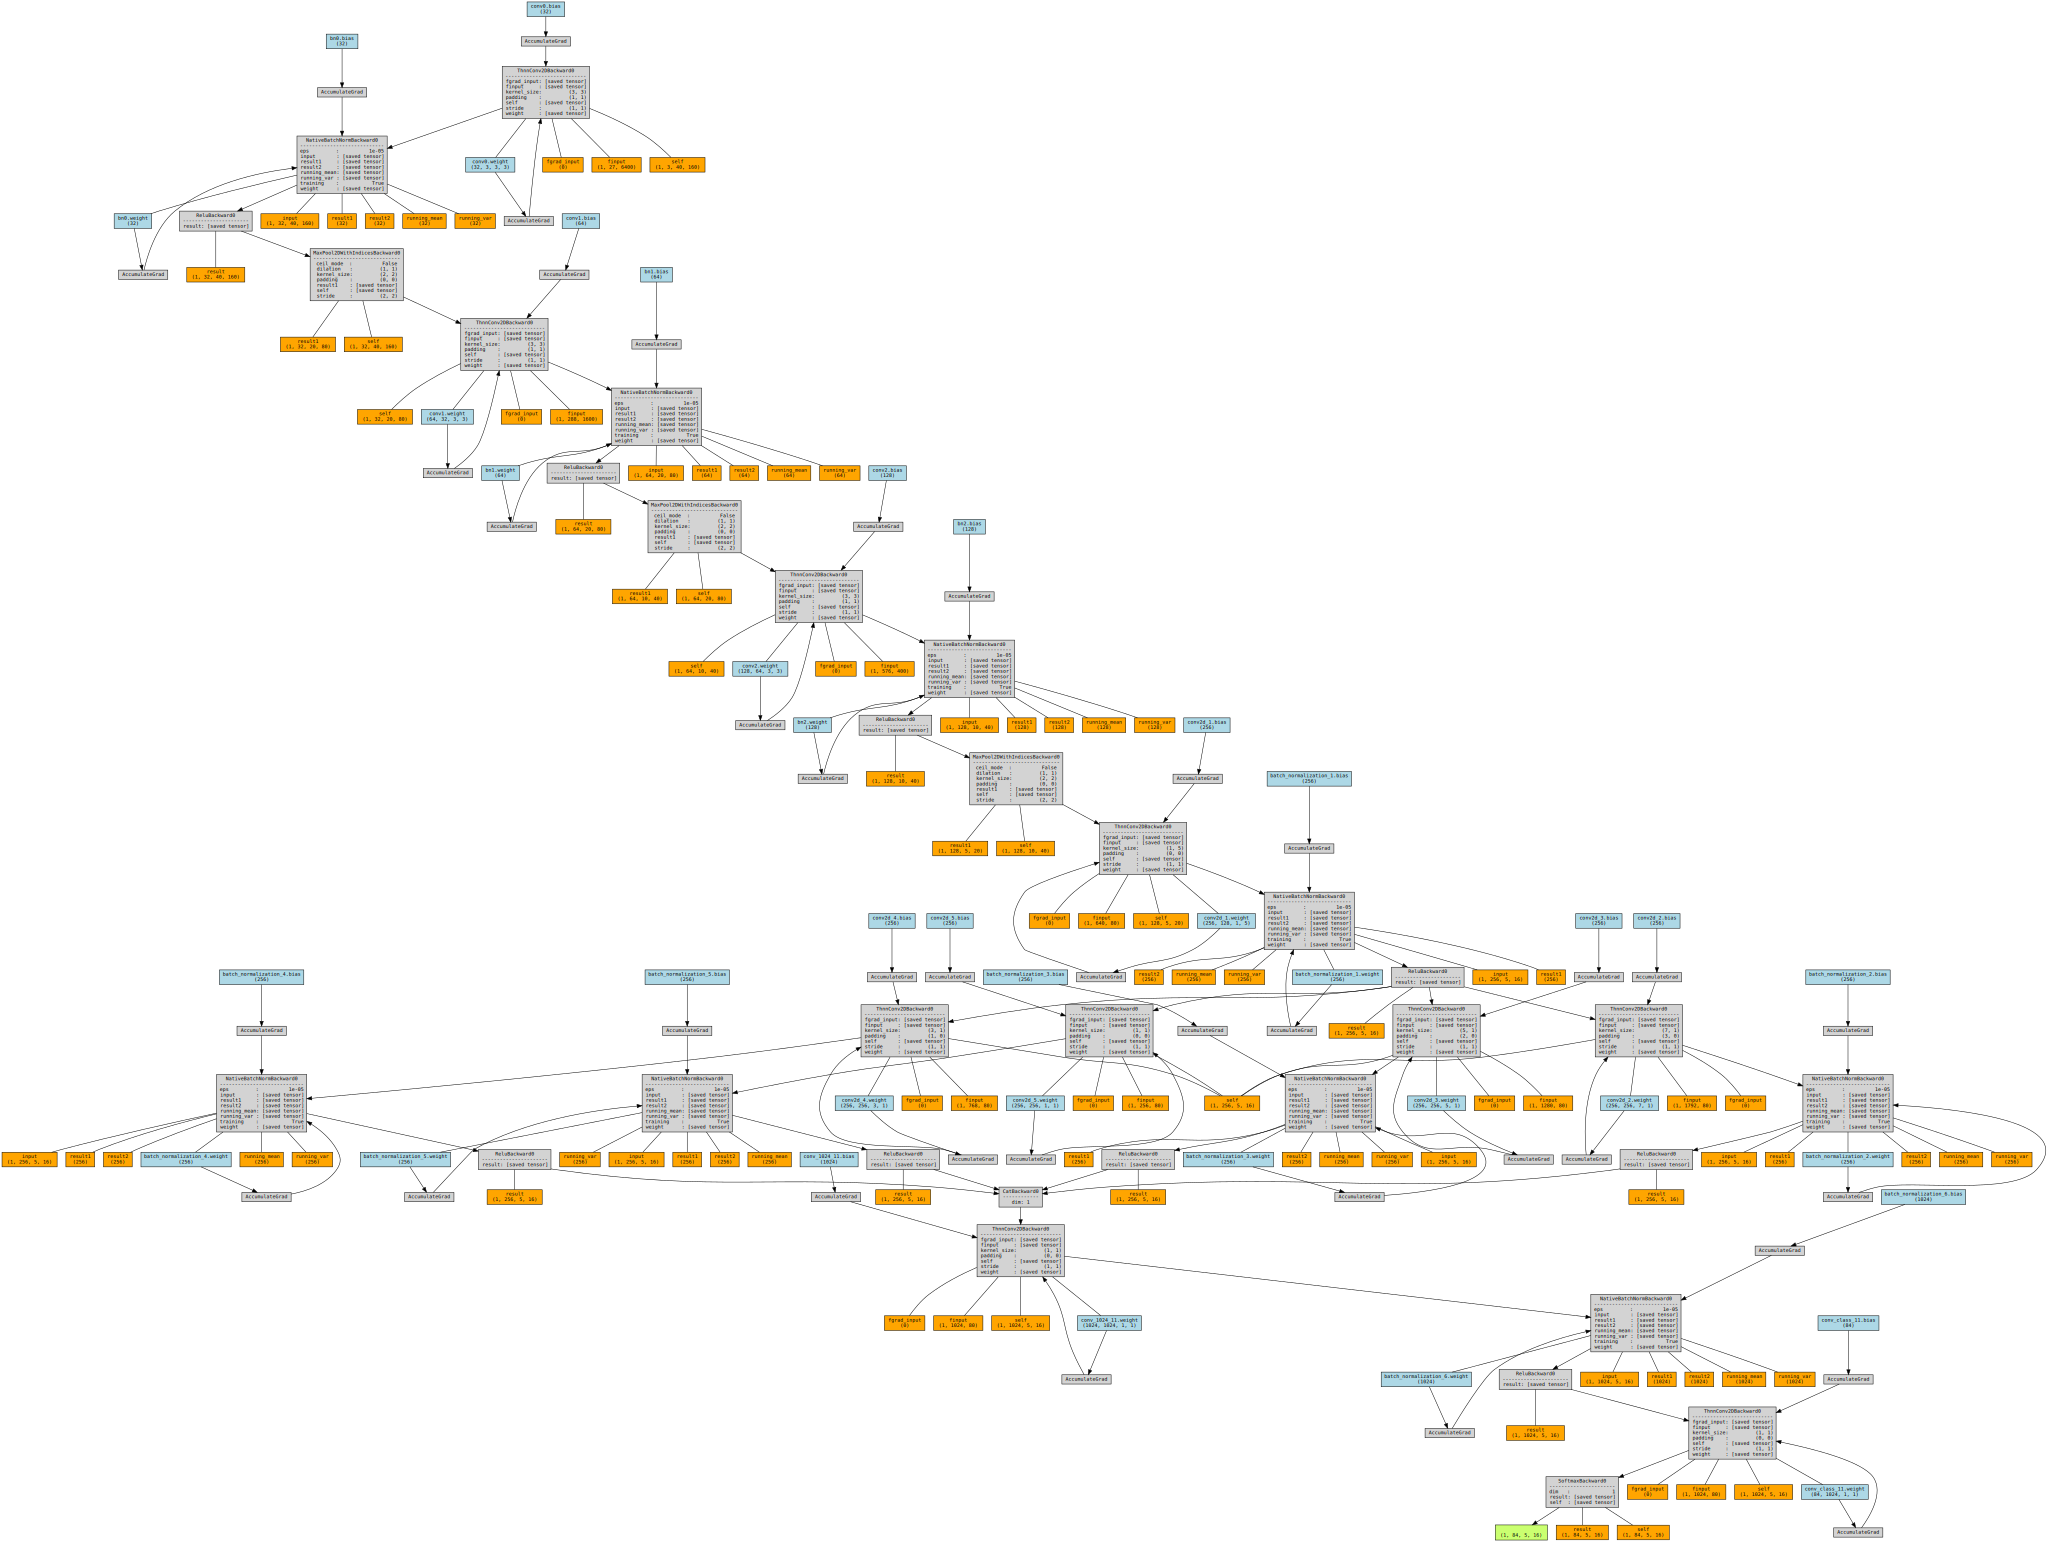

In [39]:
#输出模型结构
from torchviz import make_dot
from torchsummary import summary

summary(model,(3, 40, 160))

x = torch.zeros(1, 3, 40, 160, dtype=torch.float, requires_grad=False)
out = model(x)
make_dot(out, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [21]:
#模型训练
model = model.train()

In [54]:
import time
import datetime
#训练历史记录
loss_history = []
start_time1 = time.time()
for epoch in range(20):
    pbar = tqdm(dataloader_train)
    time_str = datetime.datetime.now().isoformat()
    start_time2 = time.time()
    for batch_image, batch_carnumber in pbar:
        batch_image =  batch_image.float()
        batch_output = model(batch_image).squeeze()
        loss = criterion(batch_output.permute(2,0,1).log(), 
                         batch_carnumber, 
                         torch.tensor([batch_output.shape[2]]*batch_output.shape[0]), 
                         torch.tensor([batch_carnumber.shape[1]]*batch_carnumber.shape[0]))
        pbar.set_description(f'epoch {epoch + 1}, loss:{loss.item():.4f}')
        loss_history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch %d, loss_total = %.4f, costs %.1f s' % (epoch + 1, loss, time.time() - start_time2))
end_time = time.time()
print("Training over. It costs {:.2f} minutes".format((end_time - start_time1) / 60))

  0%|                                                   | 0/852 [00:00<?, ?it/s]/var/folders/2c/2x14z76n6nl1n0dtz1rq32n00000gn/T/ipykernel_10365/2203372728.py:20: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  carnumber = np.zeros((len(text)), dtype=np.long)
epoch 1, loss:0.0220: 100%|███████████████████| 852/852 [00:29<00:00, 28.47it/s]


epoch 1, loss_total = 0.0220, costs 29.9 s


epoch 2, loss:0.0219: 100%|███████████████████| 852/852 [00:29<00:00, 29.20it/s]


epoch 2, loss_total = 0.0219, costs 29.2 s


epoch 3, loss:0.0147: 100%|███████████████████| 852/852 [00:27<00:00, 31.28it/s]


epoch 3, loss_total = 0.0147, costs 27.2 s


epoch 4, loss:0.0047: 100%|███████████████████| 852/852 [00:26<00:00, 31.99it/s]


epoch 4, loss_total = 0.0047, costs 26.6 s


epoch 5, loss:0.0246: 100%|███████████████████| 852/852 [00:25<00:00, 33.63it/s]


epoch 5, loss_total = 0.0246, costs 25.3 s


epoch 6, loss:0.0075: 100%|███████████████████| 852/852 [00:25<00:00, 33.30it/s]


epoch 6, loss_total = 0.0075, costs 25.6 s


epoch 7, loss:0.0465: 100%|███████████████████| 852/852 [00:25<00:00, 32.90it/s]


epoch 7, loss_total = 0.0465, costs 25.9 s


epoch 8, loss:0.0254: 100%|███████████████████| 852/852 [00:25<00:00, 33.40it/s]


epoch 8, loss_total = 0.0254, costs 25.5 s


epoch 9, loss:0.0719: 100%|███████████████████| 852/852 [00:26<00:00, 32.51it/s]


epoch 9, loss_total = 0.0719, costs 26.2 s


epoch 10, loss:0.0183: 100%|██████████████████| 852/852 [00:25<00:00, 32.79it/s]


epoch 10, loss_total = 0.0183, costs 26.0 s


epoch 11, loss:0.0424: 100%|██████████████████| 852/852 [00:28<00:00, 29.93it/s]


epoch 11, loss_total = 0.0424, costs 28.5 s


epoch 12, loss:0.0062: 100%|██████████████████| 852/852 [00:26<00:00, 32.13it/s]


epoch 12, loss_total = 0.0062, costs 26.5 s


epoch 13, loss:0.0138: 100%|██████████████████| 852/852 [00:26<00:00, 32.58it/s]


epoch 13, loss_total = 0.0138, costs 26.1 s


epoch 14, loss:0.0223: 100%|██████████████████| 852/852 [00:25<00:00, 33.03it/s]


epoch 14, loss_total = 0.0223, costs 25.8 s


epoch 15, loss:0.0119: 100%|██████████████████| 852/852 [00:25<00:00, 32.93it/s]


epoch 15, loss_total = 0.0119, costs 25.9 s


epoch 16, loss:0.0784: 100%|██████████████████| 852/852 [00:25<00:00, 33.22it/s]


epoch 16, loss_total = 0.0784, costs 25.6 s


epoch 17, loss:0.0564: 100%|██████████████████| 852/852 [00:25<00:00, 33.50it/s]


epoch 17, loss_total = 0.0564, costs 25.4 s


epoch 18, loss:0.0134: 100%|██████████████████| 852/852 [00:25<00:00, 33.26it/s]


epoch 18, loss_total = 0.0134, costs 25.6 s


epoch 19, loss:0.0159: 100%|██████████████████| 852/852 [00:25<00:00, 33.20it/s]


epoch 19, loss_total = 0.0159, costs 25.7 s


epoch 20, loss:0.0143: 100%|██████████████████| 852/852 [00:26<00:00, 32.08it/s]

epoch 20, loss_total = 0.0143, costs 26.6 s
Training over. It costs 8.82 minutes


In [55]:
torch.save(model, 'model-lastest.pth')

In [56]:
#构建验证模型
model = model.eval()

#计算正确率指标
correct = 0
for sample in tqdm(dataset_val):
    sample_image = sample[0]
    sample_carnumber = sample[1]
    output = decode_prob(model(torch.tensor(sample_image[np.newaxis,...]).float())[0].squeeze().detach().numpy())
    truth = decode(sample_carnumber)
    
    if output == truth:
        correct += 1
#输出正确率结果
print(correct/len(dataset_val))

  0%|                                                   | 0/619 [00:00<?, ?it/s]/var/folders/2c/2x14z76n6nl1n0dtz1rq32n00000gn/T/ipykernel_10365/2203372728.py:20: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  carnumber = np.zeros((len(text)), dtype=np.long)
100%|████████████████████████████████████████| 619/619 [00:02<00:00, 234.56it/s]

0.6639741518578353


In [25]:
#加载模型
model = torch.load('model-lastest.pth',map_location="cpu")
for m in model.modules():
    if 'Conv' in str(type(m)):
        setattr(m, 'padding_mode', 'zeros')

In [79]:
#定义模型使用方法
def eval(file):
    image = io.imread(file)
    #输入图片可视化
    plt.imshow(image)
    image = cv2.resize(image, (160,40)).transpose((2,1,0))
    output = model(torch.tensor(image[np.newaxis,...]).float())[0].squeeze().detach().numpy()
    return decode_prob(output)

'宁C0B5GP'

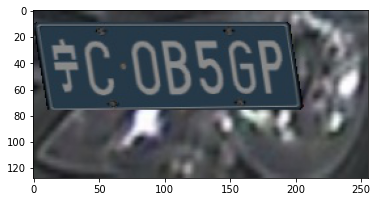

In [80]:
eval('gen_res_val/29/宁C0B5GP.jpg')

'青AK2ZAG'

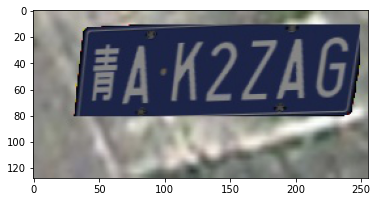

In [65]:
eval('test1.jpg')

'沪YTT1'

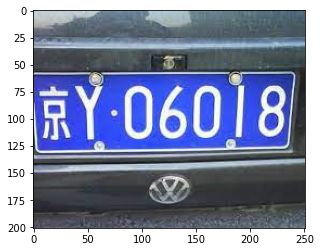

In [86]:
eval('my-test3.jpg')

'青AK2ZAG'

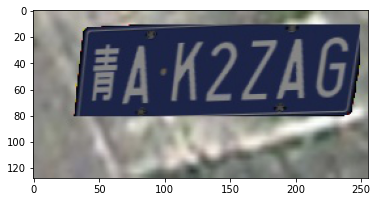

In [83]:
eval('test1.jpg')

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 4, 160, 40] to have 3 channels, but got 4 channels instead

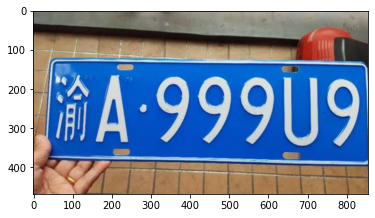

In [75]:
eval('my-test6.png')

'沪YTT1'

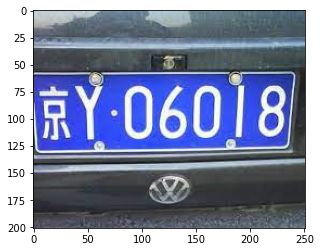

In [63]:
eval('my-test3.jpeg')

'沪G8'

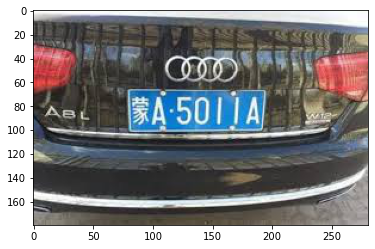

In [62]:
eval('my-test4.jpeg')

'冀G2'

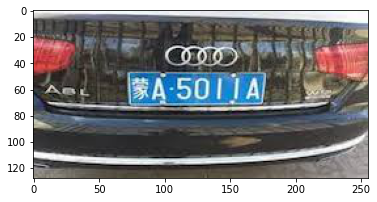

In [85]:
eval('my-test4.jpeg')

'沪YTT1'

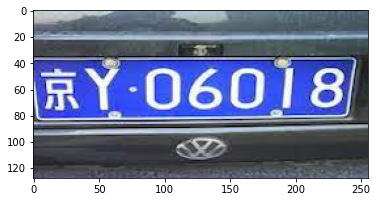

In [87]:
eval('my-test3.jpg')